# Position of bees on Honeycomb and Distances

In [1]:
import os
import math
from collections import Counter

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from bb_binary import FrameContainer, Repository

matplotlib.rc("figure", figsize=(12, 6))
sns.set_style('white')

repo = Repository('/Users/alexa/Projects/bees-sna/2015/')

In [48]:
distances = [] # list of all distances (bee1, bee2, distance)

for frame, container in repo.iter_frames():
    positions = []
    for detection in frame.detectionsUnion.detectionsDP:
        positions.append((detection.xpos, detection.ypos, detection.decodedId))

    # Calculate distances for this frame
    for i in range(len(positions)-2):
        bee1 = positions[i]
        for j in range(i+1, len(positions)-1):
            bee2 = positions[j]
            distX = bee2[0] - bee1[0]
            distY = bee2[1] - bee1[1]
            dist = math.sqrt(distX*distX + distY*distY)
            distances.append((dist, bee1, bee2, frame.frameIdx))

Why is the ID (# global unique id of the frame) always 0?

Number of all distances over all frames

In [49]:
print(len(distances))

3861138


Minimum and Maximal Distance between bees


In [50]:
list = [x[0] for x in distances]
dists = np.array(list)
print(np.min(dists))
print(np.max(dists))

60.0
4451.60431755


## Histogramm of Distances

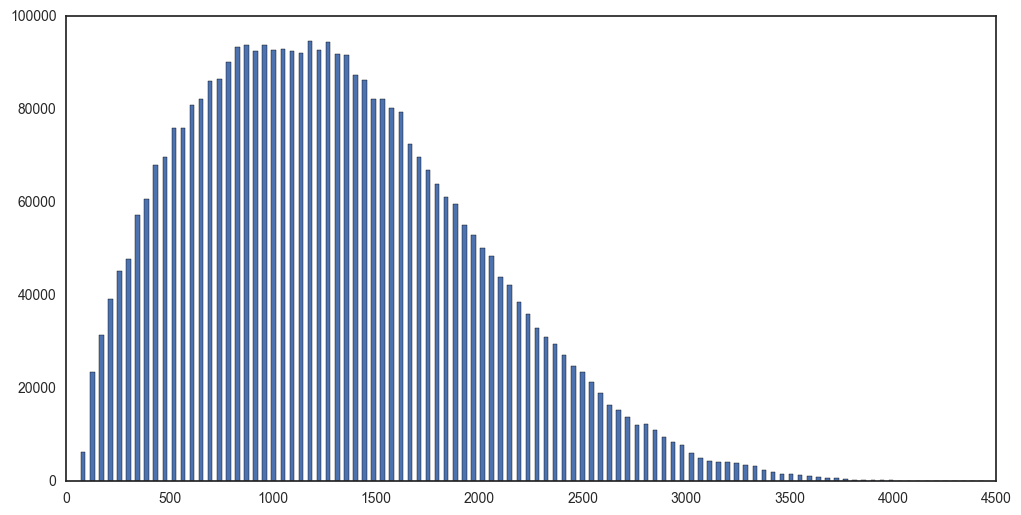

In [51]:
hist, bins = np.histogram(dists, bins=100)
width = 0.5* (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Looking at very close bees
How to choose the right distance? How to calculate it?

In [60]:
max = 100
list = [x for x in distances if x[0] <= max]

In [61]:
num_close_bees= (len(list))
print(num_close_bees)

4708


## Calculating IDs for close bees
What IDs are involved? For each succesive timeframe, do the same bees stay together?

First calculate all the IDs, those who can not be translated for sure (63) are just thrown away.

In [68]:
# Calculating ids with delta 63 (just for testing)
def getId(delta, id):

    c = 0
    number = 0
    for i in range(len(id)):
        if (id[i] <= 0 + delta):
            c = c + 1
        if (id[i] >= 255 - delta):
            c = c + 1
            number = number + 2**i
    # Add detected number in decimal
    if c == 12:
        return number
    else:
        return -1
    
delta = 63

list = [x for x in list if ((getId(delta, x[1][2]) > -1) and (getId(delta, x[2][2])) > -1)]    

In [75]:
print((100*len(list))/num_close_bees)
print(len(list))

68.5429056924384
3227


So we lost kind of a lot of bees when calculating the IDs in decimal.

In [72]:
bees = []
for x in list:
    bees.append((getId(delta, x[1][2]), getId(delta, x[2][2]), x[3]))
    

In [73]:
print(len(bees))

3227


## Are there any ID combinations which occur in consecutive frames?
How long are those sequences?